### **Project Introduction**

Beta Bank is experiencing a steady churn of customers, impacting its profitability. Studies show it is more cost-effective to retain existing customers than to acquire new ones. The bank seeks to predict which customers are likely to leave, allowing them to launch targeted retention campaigns.

**Objective**:  
Develop a machine learning model to predict customer churn, enabling the implementation of an effective user retention program.


### **Solution Plan**

To address the problem, we will follow these steps:

1. **Data Loading and Exploration**:  
   - Load and examine the dataset to understand its structure, completeness, and characteristics.  
   - Identify and address missing values, outliers, and irrelevant columns.  

2. **Data Preprocessing**:  
   - Encode categorical variables and handle missing values.  
   - Address class imbalance to ensure better model performance.  

3. **Model Development**:  
   - Train and evaluate multiple machine learning models using performance metrics like F1 and AUC-ROC.  

4. **Final Evaluation**:  
   - Validate the best-performing model on a test set to ensure generalization.

In [1]:
# General Libraries
import sys
import time
from pathlib import Path
from collections import Counter

# Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Scikit-Learn Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, roc_curve, precision_score, 
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

# Imbalanced Learn Libraries
from imblearn.combine import SMOTEENN

# Lazy Predict Library
from lazypredict.Supervised import LazyClassifier

# LightGBM Library
import lightgbm as lgb

# Joblib for Model Persistence
import joblib

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Set the root path
root_path = Path.cwd().parent

# Add the src directory to the system path
sys.path.append(str(root_path / 'src'))

# Import the custom ModelEvaluator class
from Evaluator import ModelEvaluator

# Set a random seed for reproducibility
SEED = 42

### **1. Loading and Exploring Data**

#### Goals:
- Understand the dataset structure and key characteristics.
- Identify missing values and potential outliers.
- Analyze the balance of the target variable (`Exited`).

#### Steps:
- Load the dataset using `pd.read_csv`.
- Use `info()` and `describe()` to examine the structure and statistical properties of the data.
- Check for missing values using `isna().sum()` and identify duplicates with `duplicated().sum()`.
- Visualize the distribution of the target variable (`Exited`) to check for class imbalance.

In [2]:
# Load the dataset
data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/Churn.csv', converters={
    "Gender": lambda x: 1 if x == "Male" else 0
})

# Display basic information about the dataset
print("Basic Information about the Dataset:")
display(data.info())

# Show summary statistics
display(data.describe())

# Check for duplicates
print(f"Número de duplicados en 'data': {data.duplicated().sum()}")

Basic Information about the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  int64  
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,9091.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,15690940.57,650.53,0.55,38.92,5.00,76485.89,1.53,0.71,0.52,100090.24,0.20
std,2886.90,71936.19,96.65,0.50,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,1.00,15565701.00,350.00,0.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,2500.75,15628528.25,584.00,0.00,32.00,2.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,5000.50,15690738.00,652.00,1.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,7500.25,15753233.75,718.00,1.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,10000.00,15815690.00,850.00,1.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


Número de duplicados en 'data': 0


### **2. Data Cleaning and Optimization**

#### Objectives:

- Remove columns that do not contribute to the prediction task.
- Optimize the dataset for memory efficiency by downcasting numerical data types.
- Analyze missing values and class balance for further preprocessing.

#### Steps:

1. **Remove Irrelevant Columns**:
   - Columns like `RowNumber`, `CustomerId`, and `Surname` are metadata that do not add predictive value and should be dropped.
2. **Analyze Missing Values**:
   - Identify columns with missing values, particularly `Tenure`, and quantify the missing data.
3. **Optimize Data Types**:
   - Reduce memory usage by downcasting integers and floats to the smallest appropriate data types.
4. **Analyze Target Class Balance**:
   - Examine the distribution of the target variable (`Exited`) to confirm class imbalance.

In [3]:
# Step 1: Drop irrelevant columns
data_cleaned = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Step 2: Analyze missing values in Tenure
missing_tenure_count = data_cleaned['Tenure'].isna().sum()
print(f"Total missing values in 'Tenure': {missing_tenure_count}")

# Step 3: Optimize data types for memory efficiency
def optimize_dataframe(df):
    """
    Downcast numerical columns to reduce memory usage.
    """
    for col in df.select_dtypes(include=['int']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

data_optimized = optimize_dataframe(data_cleaned)

# Step 4: Analyze class balance
class_balance = data_optimized['Exited'].value_counts(normalize=True)
print("\nClass Distribution of 'Exited':")
print(class_balance)

# Step 5: Summary of missing values
missing_values_summary = data_optimized.isna().sum()
print("\nSummary of Missing Values:")
print(missing_values_summary)

# Display data types after optimization
print("\nData Types After Optimization:")
print(data_optimized.dtypes)

Total missing values in 'Tenure': 909

Class Distribution of 'Exited':
Exited
0   0.80
1   0.20
Name: proportion, dtype: float64

Summary of Missing Values:
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Data Types After Optimization:
CreditScore          int16
Geography           object
Gender                int8
Age                   int8
Tenure             float32
Balance            float64
NumOfProducts         int8
HasCrCard             int8
IsActiveMember        int8
EstimatedSalary    float64
Exited                int8
dtype: object


### **3. Encoding Categorical Features and Imputation of Missing Values**

#### Objectives:

1. **Encode Categorical Features**:
   - Convert categorical variables into numerical format using one-hot encoding.
   - Drop the first category for each feature to avoid multicollinearity.
2. **Impute Missing Values**:
   - Use advanced imputation techniques, specifically `IterativeImputer`, to fill missing values in a statistically sound way.

In [4]:

# Step 1: One-hot encode categorical features
categorical_columns = data_optimized.select_dtypes(include=['object']).columns
data_optimized = pd.get_dummies(
    data_optimized,
    columns=categorical_columns,
    drop_first=True
)

# Step 2: Set up Iterative Imputer
iterative_imputer = IterativeImputer(max_iter=10, random_state=SEED)

# Step 3: Impute missing values
data_imputed = pd.DataFrame(
    iterative_imputer.fit_transform(data_optimized),
    columns=data_optimized.columns
)

# Step 4: Verify the imputation
missing_values_after_imputation = data_imputed.isna().sum()
print("\nMissing Values After Imputation:")
print(missing_values_after_imputation)


Missing Values After Imputation:
CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_Germany    0
Geography_Spain      0
dtype: int64


#### Steps and Explanations:

1. **One-Hot Encoding**:
   - Convert all categorical features (`object` dtype) into dummy variables using `pd.get_dummies`.
   - Set `drop_first=True` to avoid redundant columns.
2. **Iterative Imputation**:
   - Use `IterativeImputer` from `sklearn` to fill missing values.
   - The imputer uses regression models iteratively to estimate missing values based on the relationships between features.
3. **Verify Imputation**:
   - Confirm that all missing values are filled by checking for `NaN` in the resulting DataFrame.

### **4. Addressing Class Imbalance and Splitting the Data**

#### Objectives:



1. **Address Class Imbalance**:
   - Use **SMOTEENN**, a combination of SMOTE (Synthetic Minority Over-sampling Technique) and ENN (Edited Nearest Neighbors), to resample the dataset. This technique balances the classes by oversampling the minority class and undersampling the majority class, removing noisy examples.
2. **Split the Data**:
   - Divide the resampled data into training, validation, and test sets:
     - Training set: 60%
     - Validation set: 20%
     - Test set: 20%

In [5]:
# Split the data into train, validation, and test sets (no resampling yet)
X_train, X_temp, y_train, y_temp = train_test_split(
    data_imputed.drop(columns='Exited'), data_imputed['Exited'], test_size=0.4, random_state=SEED, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

# Verify class distribution in splits
print("\nClass Distribution Before Resampling:")
print(f"Training set: {Counter(y_train)}")
print(f"Validation set: {Counter(y_valid)}")
print(f"Test set: {Counter(y_test)}")

# Suppress warnings for the following block of code
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

    # Initialize SMOTEENN
    smote_enn = SMOTEENN(random_state=SEED)

    # Resample only the training data
    X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Verify class distribution after resampling
print("\nClass Distribution After Resampling:")
print(f"Resampled Training set: {Counter(y_train_resampled)}")

# Final dataset shapes
print("\nData Splits and Class Balance After Resampling:")
print(f"Training set: {X_train_resampled.shape}, Class Balance: {y_train_resampled.value_counts(normalize=True).to_dict()}")
print(f"Validation set: {X_valid.shape}, Class Balance: {y_valid.value_counts(normalize=True).to_dict()}")
print(f"Test set: {X_test.shape}, Class Balance: {y_test.value_counts(normalize=True).to_dict()}")


Class Distribution After Resampling:
[(0.0, 2896), (1.0, 3703)]

Data Splits and Class Balance:
Training set: (3959, 11), Class Balance: {1.0: 0.5612528416266734, 0.0: 0.4387471583733266}
Validation set: (1320, 11), Class Balance: {1.0: 0.5613636363636364, 0.0: 0.43863636363636366}
Test set: (1320, 11), Class Balance: {1.0: 0.5606060606060606, 0.0: 0.4393939393939394}


#### Steps and Explanations:

1. **SMOTEENN Resampling**:
   - SMOTE generates synthetic samples for the minority class based on existing data.
   - ENN removes noisy and ambiguous samples from the majority class, improving data quality.
2. **Data Splitting**:
   - First, split the resampled data into training (60%) and temporary (40%) sets.
   - Further split the temporary set into validation (20%) and test (20%) sets.
3. **Verify the Class Distribution**:
   - Confirm the new class balance after resampling and the class proportions in each split.

Inpute x["tenure"] using Multivariate feature imputation

Hacemos la separacion de X_resampled, y_resampled en los dataframes:
train, test, valid

Usamos `random_seed = 42`, y estratificacion en la columna objetivo `y_resampled` para asegurarnos que tengan la misma probabilidad de tener churn en cada dataset.

### **5. Evaluate Baseline Models Using LazyClassifier**

#### Objectives:

1. Quickly compare the performance of various classification models on the training and validation datasets.
2. Use **recall** as a custom evaluation metric to prioritize identifying churned customers (`Exited = 1`).

#### Steps and Explanations:

1. **LazyClassifier**:
   - LazyClassifier is a wrapper that evaluates multiple classification models without the need for manual instantiation or training.
   - It simplifies baseline model comparison by providing key metrics in a single table.
2. **Custom Metric (Recall)**:
   - Recall is used as the primary evaluation metric, as the project goal emphasizes minimizing false negatives (i.e., identifying churned customers who might otherwise be missed).
3. **Execution**:
   - Fit LazyClassifier on the training and validation sets.
   - Generate a summary table with model performance metrics, including recall.

In [6]:
# Initialize LazyClassifier with recall as the custom metric
clf = LazyClassifier(
    verbose=0,  # Suppress detailed logging
    ignore_warnings=True,  # Ignore model-specific warnings
    custom_metric=recall_score  # Use recall as the custom evaluation metric
)

# Fit LazyClassifier on the training and validation sets
models, predictions = clf.fit(X_train, X_valid, y_train, y_valid)

# Display the summary of model performances
print("Baseline Model Performance Metrics:")
display(models)

 97%|█████████▋| 31/32 [00:04<00:00,  6.86it/s]  File "c:\Users\Guill\Miniconda3\envs\da\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Guill\Miniconda3\envs\da\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Guill\Miniconda3\envs\da\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Guill\Miniconda3\envs\da\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
100%|██████████| 32/32 [00:04<00:00,  6.61it/s]

[LightGBM] [Info] Number of positive: 2222, number of negative: 1737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 3959, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561253 -> initscore=0.246248
[LightGBM] [Info] Start training from score 0.246248
Baseline Model Performance Metrics:


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,recall_score,Time Taken
Model,,,,,,
LGBMClassifier,0.92,0.93,0.93,0.92,0.91,0.14
RandomForestClassifier,0.92,0.92,0.92,0.92,0.92,0.60
ExtraTreesClassifier,0.91,0.91,0.91,0.91,0.91,0.37
BaggingClassifier,0.89,0.89,0.89,0.89,0.89,0.15
AdaBoostClassifier,0.89,0.89,0.89,0.89,0.89,0.26
DecisionTreeClassifier,0.86,0.86,0.86,0.86,0.89,0.03
ExtraTreeClassifier,0.86,0.85,0.85,0.86,0.88,0.02
SVC,0.86,0.85,0.85,0.86,0.88,0.66
LabelSpreading,0.85,0.85,0.85,0.85,0.91,0.57


### **6. Building and Evaluating a LightGBM Model**

#### Objectives:

1. **Train a LightGBM Classifier**:
   - Utilize LightGBM, a high-performance gradient boosting framework, to train a model for churn prediction.
2. **Evaluate the Model**:
   - Predict on the validation set and prepare for further evaluation using relevant metrics (e.g., F1, recall, AUC-ROC).

In [7]:
# Step 1: Initialize and train LightGBM Classifier
clf = lgb.LGBMClassifier(random_state=SEED)  # Use SEED for reproducibility
clf.fit(X_train, y_train)

# Step 2: Predict on validation set
y_pred = clf.predict(X_valid)
y_pred_proba = clf.predict_proba(X_valid)[:, 1]  # For AUC-ROC

# Step 3: Evaluate the model
print("Classification Report (Validation Set):")
print(classification_report(y_valid, y_pred))

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f"AUC-ROC (Validation Set): {roc_auc:.4f}")

# Calculate F1 Score
f1 = f1_score(y_valid, y_pred)
print(f"F1 Score (Validation Set): {f1:.4f}")

[LightGBM] [Info] Number of positive: 2222, number of negative: 1737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 3959, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561253 -> initscore=0.246248
[LightGBM] [Info] Start training from score 0.246248
Classification Report (Validation Set):
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       579
         1.0       0.95      0.92      0.93       741

    accuracy                           0.93      1320
   macro avg       0.92      0.93      0.92      1320
weighted avg       0.93      0.93      0.93      1320

AUC-ROC (Validation Set): 0.9734
F1 Score (Validation Set): 0.9327


### 7 . **Evaluating the LightGBM Model**

#### Objectives:

1. **Comprehensive Evaluation**:
   - Use a custom `ModelEvaluator` class to calculate and display key evaluation metrics, plot the confusion matrix, and visualize the ROC curve.
2. **Key Metrics**:
   - Metrics such as precision, recall, F1 score, and AUC-ROC will help assess model performance comprehensively.
   - The confusion matrix provides a clear view of true positives, false positives, true negatives, and false negatives.
3. **Visualization**:
   - The ROC curve visually illustrates the trade-off between sensitivity and specificity.

### **Scores**

Accuracy Score	: 0.9258
Precision		: 0.9497
Recall		: 0.9163
F1 Score		: 0.9327
ROC AUC Score	: 0.9734

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       579
         1.0       0.95      0.92      0.93       741

    accuracy                           0.93      1320
   macro avg       0.92      0.93      0.92      1320
weighted avg       0.93      0.93      0.93      1320



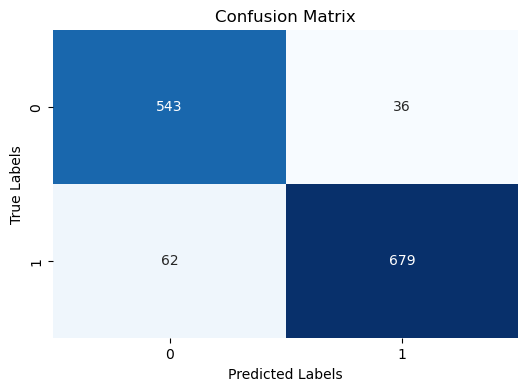

In [8]:
# Initialize the evaluator with predictions
evaluator = ModelEvaluator(y_true=y_valid, y_pred=y_pred, y_proba=clf.predict_proba(X_valid)[:, 1])

# Display scores
evaluator.display_scores()

# Plot the confusion matrix
evaluator.plot_confusion_matrix()

# Plot the ROC curve
evaluator.plot_roc_curve()

This cell evaluates the performance of the trained model. It calculates key metrics like accuracy, precision, recall, F1 score, and AUC-ROC to summarize how well the model performs. Additionally, it visualizes the confusion matrix to show the breakdown of correct and incorrect predictions and plots the ROC curve to illustrate the model's ability to distinguish between churned and non-churned customers.

### **8. Analyzing Feature Importance**

#### Objectives:

1. **Extract Feature Importance**:
   - Use LightGBM’s built-in `feature_importances_` attribute to determine the contribution of each feature to the model's predictions.
2. **Visualize Importance**:
   - Create a bar plot to highlight the most significant features, allowing for insights into what drives customer churn.

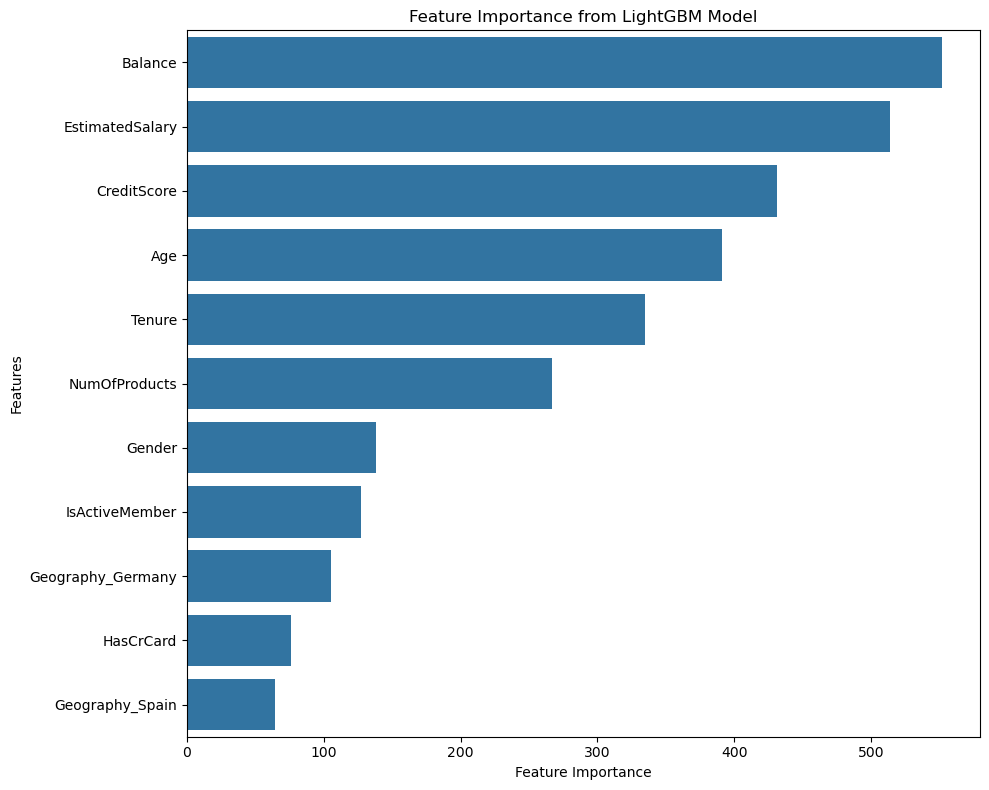

In [9]:
# Feature Importance
importance = clf.feature_importances_
features = X_train.columns

# Step 2: Create a DataFrame for better visualization
df_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# Step 3: Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=df_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from LightGBM Model')
plt.tight_layout()
plt.show()

### **9. Hyperparameter Tuning with RandomizedSearchCV**

#### Objectives:

1. **Optimize the LightGBM Model**:
   - Use `RandomizedSearchCV` to explore a wide range of hyperparameters and identify the best-performing configuration.
2. **Evaluation**:
   - Evaluate the tuned model on the test set using metrics like accuracy, recall, precision, and F1 score.
3. **Save Results**:
   - Save the cross-validation results for further analysis.

In [10]:
# Define the parameter grid for LGBMClassifier
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'subsample_for_bin': np.linspace(20000, 300000, 10).astype(int),
    'objective': ['binary'],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_samples': [20, 40, 100],
    'reg_alpha': [0.0, 0.1, 0.5],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    n_jobs=-1,
    cv=3,
    scoring='f1',
    verbose=2,
    random_state=42
)

# Start timer
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

# Display execution time
print(f"RandomizedSearchCV completed in {end_time - start_time:.2f} seconds")

# Save cross-validation results
results_path = root_path / 'data' / 'processed' / "random_search_results.csv"
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results.to_csv(results_path, index=False)
print(f"Randomized search results saved to: {results_path}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 2222, number of negative: 1737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 3959, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561253 -> initscore=0.246248
[LightGBM] [Info] Start training from score 0.246248
RandomizedSearchCV completed in 26.45 seconds
Randomized search results saved to: t:\Mi unidad\wdir\s10-beta_bank\data\processed\random_search_results.csv


### **Scores**

Accuracy Score	: 0.9280
Precision		: 0.9499
Recall		: 0.9204
F1 Score		: 0.9349
ROC AUC Score	: 0.9735

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       579
         1.0       0.95      0.92      0.93       741

    accuracy                           0.93      1320
   macro avg       0.93      0.93      0.93      1320
weighted avg       0.93      0.93      0.93      1320



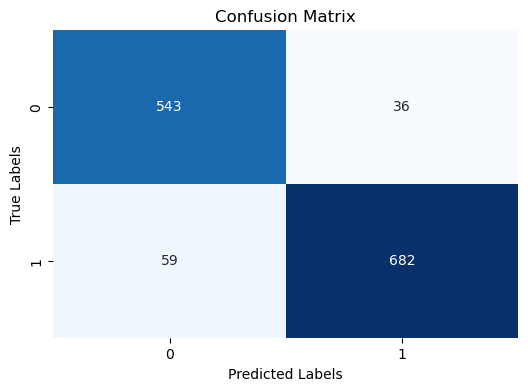

In [11]:
evaluator = ModelEvaluator(
    y_true = y_valid,
    y_pred = random_search.predict(X_valid),
    y_proba = random_search.predict_proba(X_valid)[:, 1]
    )

# Display scores
evaluator.display_scores()

# Plot the confusion matrix
evaluator.plot_confusion_matrix()

# Plot the ROC curve
evaluator.plot_roc_curve()

## 10. Evaluate on test set

Evaluating a machine learning model on a separate dataset (not the training data) is vital. This process helps detect overfitting (where the model learns training data quirks instead of general patterns), assesses the model's ability to generalize to new, unseen data, ensures robustness (consistent performance across varied data), and helps avoid bias present in the training data. Essentially, it provides a more realistic measure of real-world performance.

### **Scores**

Accuracy Score	: 0.9295
Precision		: 0.9487
Recall		: 0.9243
F1 Score		: 0.9363
ROC AUC Score	: 0.9742

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92       580
         1.0       0.95      0.92      0.94       740

    accuracy                           0.93      1320
   macro avg       0.93      0.93      0.93      1320
weighted avg       0.93      0.93      0.93      1320



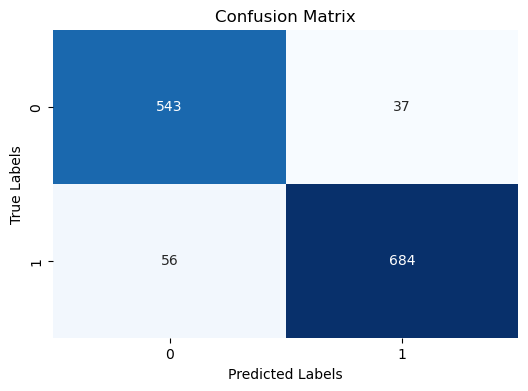

In [12]:
evaluator = ModelEvaluator(
    y_true=y_test,
    y_pred=random_search.predict(X_test),
    y_proba=random_search.predict_proba(X_test)[:, 1]
)

# Display scores
evaluator.display_scores()

# Plot the confusion matrix
evaluator.plot_confusion_matrix()

# Plot the ROC curve
evaluator.plot_roc_curve()

The test set evaluation ensures that the model is robust, unbiased, and ready to perform effectively in real-world applications.

### **10. Saving the Model and Artifacts**

#### Objectives:

1. **Model Persistence**:
   - Save the trained LightGBM model for reuse in prediction pipelines or deployment.
2. **Preprocessor Persistence**:
   - Save the `IterativeImputer` used for handling missing values to ensure consistency in preprocessing new data.
3. **Feature Importance**:
   - Save the feature importance values to a CSV file for reporting and analysis.

In [13]:
# Step 1: Save the trained LightGBM model
model_path = 'model.pkl'
joblib.dump(random_search, model_path)
print(f"Model saved as: {model_path}")

# Step 2: Save the preprocessing pipeline
preprocessor_path = 'preprocessor.pkl'
joblib.dump(iterative_imputer, preprocessor_path)
print(f"Preprocessor saved as: {preprocessor_path}")

# Step 3: Save the feature importance data
feature_importance_path = root_path / 'data' / 'processed' / 'feature_importance.csv'
df_importance.to_csv(feature_importance_path, index=False)
print(f"Feature importance saved as: {feature_importance_path}")

Model saved as: model.pkl
Preprocessor saved as: preprocessor.pkl
Feature importance saved as: t:\Mi unidad\wdir\s10-beta_bank\data\processed\feature_importance.csv
